# Language Translator

In [1]:
import nltk
import pandas as pd
import numpy as np

import string
import re
from numpy import array, argmax, random, take
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text("fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)
fra_eng = fra_eng[:50000,:]
fra_eng

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go.', 'Marche.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go.', 'Bouge !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['No one wants to fight.', 'Personne ne veut se battre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2091157 (CK) & #2101587 (sacredceltic)'],
       ['No one wants to speak.', 'Personne ne veut parler.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2091158 (CK) & #2101585 (sacredceltic)'],
       ['No one was helping us.', 'Personne ne nous aidait.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4950734 (CK) & #5899355 (Aiji)']],
      dtype='<U349')

### Create and Pre-Process DataFrame

In [3]:
# create dataframe
fra_eng = pd.DataFrame(fra_eng)
fra_eng = fra_eng.drop(2,axis=1)

df = fra_eng.copy()

# rename columns
df = df.rename(columns={df.columns[1]: 'Fr'})
df = df.rename(columns={df.columns[0]: 'En'})
df = df.astype(pd.StringDtype())

In [4]:
# Make lowercase
df['Fr'] = df['Fr'].str.lower()
df['En'] = df['En'].str.lower()
df.head()

,En,Fr
0,go.,va !
1,go.,marche.
2,go.,bouge !
3,hi.,salut !
4,hi.,salut.


In [5]:
# Remove Punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df['En'] = df['En'].apply(remove_punctuations)
df['Fr'] = df['Fr'].apply(remove_punctuations)
df.head()

,En,Fr
0,go,va
1,go,marche
2,go,bouge
3,hi,salut
4,hi,salut


### Text to Sequence Conversion (converts text to tokens)

Visualise the length of the sentences.

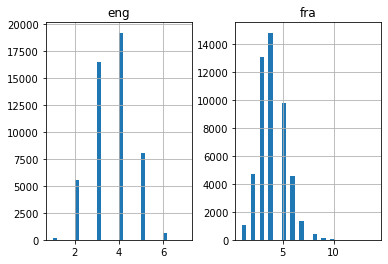

In [6]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in df['En']:
      eng_l.append(len(i.split()))

for i in df['Fr']:
      fra_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

length_df.hist(bins = 30)
plt.show()

In [7]:
from pickle import load
from pickle import dump
from numpy.random import rand
# reduce dataset size
df = df.head(10000)
# random shuffle
# from numpy.random import shuffle
# shuffle(df)
# split into train/test
train = df.head(8000)
test = df.tail(2000)
# save
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
save_clean_data(df, 'english-french-both_v3.pkl')
save_clean_data(train, 'english-french-train_v3.pkl')
save_clean_data(test, 'english-french-test_v3.pkl')

Saved: english-french-both_v3.pkl
Saved: english-french-train_v3.pkl
Saved: english-french-test_v3.pkl


In [8]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# load datasets
df = load_clean_sentences('english-french-both_v3.pkl')
train = load_clean_sentences('english-french-train_v3.pkl')
test = load_clean_sentences('english-french-test_v3.pkl')

In [9]:
train.head()

,En,Fr
0,go,va
1,go,marche
2,go,bouge
3,hi,salut
4,hi,salut


In [10]:
df = df[["En", "Fr"]].to_numpy()
train = train[["En", "Fr"]].to_numpy()
test = test[["En", "Fr"]].to_numpy()

In [11]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [12]:
# prepare English tokenizer
eng_tokenizer = create_tokenizer(df[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(df[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare French tokenizer
fra_tokenizer = create_tokenizer(df[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(df[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))

English Vocabulary Size: 2027
English Max Length: 5
French Vocabulary Size: 4756
French Max Length: 10


Function to prepare the sequences. It will also perform sequence padding to a maximum sentence length

In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
     # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
     # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

Define Seq2Seq model architecture:

* Encoder: use an embedding layer and an LSTM layer
* Decoder: use LSTM layer followed by a dense layer

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(df, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(8000, 10)
(8000, 5)
(2000, 10)
(2000, 5)


In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [18]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 512)           2435072   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 5, 2027)           1039851   
Total params: 7,673,323
Trainable params: 7,673,323
Non-trainable params: 0
_________________________________________________________________
None


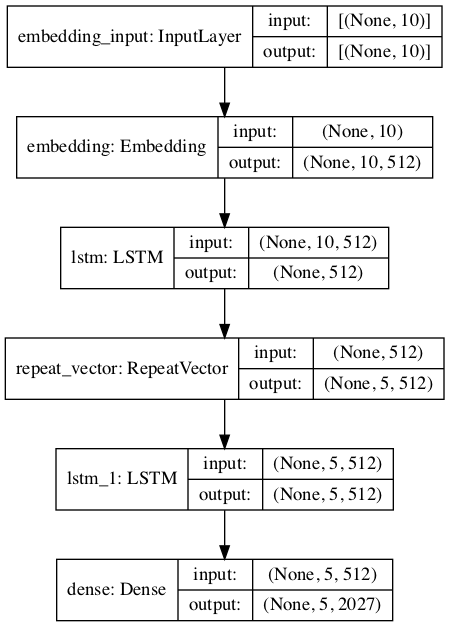

In [35]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model_v3.png', show_shapes=True)

### Training the Model

In [36]:
# fit model
filename = 'model_v3.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/20
13/13 [==============================] - 44s 3s/step - loss: 2.6402 - val_loss: 2.8095

Epoch 00001: val_loss improved from inf to 2.80955, saving model to model_v3.h5
Epoch 2/20
13/13 [==============================] - 32s 2s/step - loss: 2.4736 - val_loss: 2.7591

Epoch 00002: val_loss improved from 2.80955 to 2.75914, saving model to model_v3.h5
Epoch 3/20
13/13 [==============================] - 39s 3s/step - loss: 2.3884 - val_loss: 2.7585

Epoch 00003: val_loss improved from 2.75914 to 2.75847, saving model to model_v3.h5
Epoch 4/20
13/13 [==============================] - 35s 3s/step - loss: 2.2986 - val_loss: 2.7337

Epoch 00004: val_loss improved from 2.75847 to 2.73369, saving model to model_v3.h5
Epoch 5/20
13/13 [==============================] - 88s 7s/step - loss: 2.2181 - val_loss: 2.6500

Epoch 00005: val_loss improved from 2.73369 to 2.64996, saving model to model_v3.h5
Epoch 6/20
13/13 [==============================] - 36s 3s/step - loss: 2.1526 - val_loss

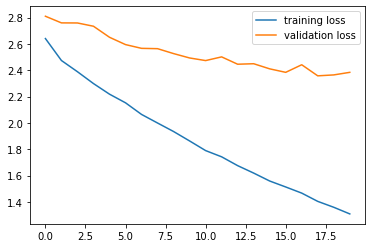

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.show()

# Evaluate the Model

In [46]:
model = load_model('model_v3.h5')
translation = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis=-1)
#translation = model.predict(testX, verbose=0)
#preds = model.predict_classes(testX)

In [47]:
translation.shape

(2000, 5)

In [48]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [49]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [50]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [51]:
# load model
model = load_model('model_v3.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[tom était mignon], target=[tom was cute], predicted=[tom was me]
src=[ne me poussez pas ], target=[dont push me], predicted=[dont push me]
src=[je marcherai], target=[i will walk], predicted=[i will it]
src=[tom la volé], target=[tom stole it], predicted=[tom was me]
src=[ils sont rouges], target=[theyre red], predicted=[theyre]
src=[prenez vos jambes à votre cou ], target=[run for it], predicted=[dont for it]
src=[je sais danser], target=[i can dance], predicted=[i was you]
src=[du calme], target=[take it easy], predicted=[come down]
src=[ne sois pas naïf ], target=[dont be naive], predicted=[dont be upset]
src=[jai aidé], target=[i helped], predicted=[i tried]
BLEU-1: 0.444544
BLEU-2: 0.290354
BLEU-3: 0.187144
BLEU-4: 0.051648
test
src=[dismen davantage], target=[tell me more], predicted=[take in]
src=[nous vous admirons], target=[we admire you], predicted=[we found]
src=[jai été engagé], target=[i was hired], predicted=[i was tom]
src=[tom pleurerait], target=[tom would c